In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

100%|██████████| 331M/331M [00:03<00:00, 102MB/s]  

Extracting model files...


Path to dataset files: /home/justin.aj/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [26]:
import os

# Folder where your images are (inside utkface_aligned_cropped)
image_folder = os.path.join(dataset_path, "utkface_aligned_cropped/UTKFace")

# New captions folder
caption_folder = os.path.join(image_folder, "captions")
os.makedirs(caption_folder, exist_ok=True)

# Gender map
gender_map = {
    "0": "male",
    "1": "female"
}

# Generate captions
for file in os.listdir(image_folder):
    if file.endswith(".jpg"):
        parts = file.split("_")
        if len(parts) >= 3:
            age = parts[0]
            gender = gender_map.get(parts[1], "person")  # fallback to "person"
            
            caption = f"photo of a {age} year old {gender}"
            
            # Save caption
            caption_path = os.path.join(caption_folder, file.replace(".jpg.chip.jpg", ".txt").replace(".jpg", ".txt"))
            with open(caption_path, "w") as f:
                f.write(caption)

print("✅ Captions created!")

✅ Captions created!


In [12]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
from peft import get_peft_model, LoraConfig

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "proj_out"],
    lora_dropout=0.1,
    bias="none",
    task_type="TEXT_TO_IMAGE",
)
pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()

In [28]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class UTKFaceDataset(Dataset):
    def __init__(self, image_folder, caption_folder, transform=None):
        self.image_folder = image_folder
        self.caption_folder = caption_folder
        self.transform = transform
        
        # List only .jpg images
        self.image_files = [file for file in os.listdir(image_folder) if file.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Apply transform if needed
        if self.transform:
            image = self.transform(image)
        
        # Find corresponding caption
        caption_name = img_name.replace(".jpg.chip.jpg", ".txt").replace(".jpg", ".txt")
        caption_path = os.path.join(self.caption_folder, caption_name)
        
        # Read caption text
        with open(caption_path, "r") as f:
            caption = f.read().strip()
        
        return image, caption

In [43]:
train_dataset = UTKFaceDataset(image_folder, caption_folder)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [44]:
from torchvision import transforms

# Define a transformation to convert PIL images to tensors
transform = transforms.ToTensor()

# Define your loss function
loss_fn = nn.MSELoss()  # or nn.L1Loss() if you prefer

optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=1e-4)
pipe.unet.train()

for epoch in range(10):
    for batch in train_dataloader:
        images, prompts = batch  # images: (B, C, H, W), prompts: list of strings
        
        # Move images to the same device as the model
        images = images.to(pipe.device)
        
        # Tokenize prompts
        inputs = pipe.tokenizer(prompts, padding="max_length", truncation=True, return_tensors="pt")
        inputs = {k: v.to(pipe.device) for k, v in inputs.items()}
        
        # Get prompt embeddings
        prompt_embeds = pipe.text_encoder(**inputs).last_hidden_state
        
        # Forward pass through the model
        outputs = pipe(prompt_embeds=prompt_embeds).images  # generated images
        
        # If outputs are a list of PIL images, convert them to tensors
        if isinstance(outputs, list):
            outputs = torch.stack([transform(o).to(pipe.device) for o in outputs])  # Convert each PIL image to tensor and stack
        
        # Ensure outputs are a tensor and require gradients
        outputs = outputs.to(pipe.device).requires_grad_()  # Make sure outputs are on the correct device and require grad
        
        # Calculate loss between generated and real images
        loss = loss_fn(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()  # Zero out gradients before backward pass
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3619


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4319


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4711


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4126


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4388


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4334


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3807


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4493


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3765


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4807


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4666


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4405


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4208


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4317


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3891


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3683


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4154


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3948


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4465


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3714


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4174


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4207


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4133


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4919


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3867


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.3701


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4234


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch [1/10], Loss: 0.4133


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import os
import warnings
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from diffusers import StableDiffusionPipeline, DDPMScheduler
from peft import get_peft_model, LoraConfig
import kagglehub
from tqdm import tqdm

# --- Setup with Error Handling ---
try:
    # --- Dataset Setup ---
    dataset_path = kagglehub.dataset_download("jangedoo/utkface-new")
    image_folder = os.path.join(dataset_path, "utkface_aligned_cropped/UTKFace")
    caption_folder = os.path.join(image_folder, "captions")
    
    # Create captions if folder doesn't exist
    os.makedirs(caption_folder, exist_ok=True)

    # --- Model Initialization ---
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    ).to("cuda")

    # Configure LoRA
    lora_config = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["to_q", "to_k", "to_v", "proj_out"],
        lora_dropout=0.1,
        bias="none",
        task_type="TEXT_TO_IMAGE",
    )
    pipe.unet = get_peft_model(pipe.unet, lora_config)
    pipe.unet.print_trainable_parameters()

    # --- Training Setup ---
    optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=1e-4)
    scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
    noise_scheduler = scheduler
    loss_fn = torch.nn.MSELoss()

    # --- Enhanced Dataset Class ---
    class UTKFaceDataset(Dataset):
        def __init__(self, image_folder, caption_folder, resolution=512):
            self.image_paths = []
            self.caption_data = {}
            
            # Scan image folder
            for f in os.listdir(image_folder):
                if f.lower().endswith((".jpg", ".jpeg", ".png", ".chip.jpg")):
                    img_path = os.path.join(image_folder, f)
                    self.image_paths.append(img_path)
                    
                    # Generate caption if missing
                    base_name = os.path.basename(f)
                    if base_name.endswith('.chip.jpg'):
                        caption_base = base_name.replace('.chip.jpg', '')
                    else:
                        caption_base = os.path.splitext(base_name)[0]
                    
                    caption_path = os.path.join(caption_folder, f"{caption_base}.txt")
                    
                    # Create caption if file doesn't exist
                    if not os.path.exists(caption_path):
                        try:
                            parts = base_name.split('_')
                            if len(parts) >= 3:  # Format: age_gender_race_date.jpg
                                age = parts[0]
                                gender = 'male' if parts[1] == '0' else 'female'
                                caption = f"photo of a {age} year old {gender}"
                                with open(caption_path, 'w') as f:
                                    f.write(caption)
                        except Exception as e:
                            caption = "photo of a person"
                            warnings.warn(f"Couldn't generate caption for {base_name}: {str(e)}")
                    
                    # Store caption data
                    self.caption_data[img_path] = caption_path

            self.transform = transforms.Compose([
                transforms.Resize(resolution),
                transforms.CenterCrop(resolution),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            
            # Load image with error handling
            try:
                image = Image.open(img_path).convert("RGB")
                image = self.transform(image)
            except Exception as e:
                warnings.warn(f"Error loading image {img_path}: {str(e)}")
                # Return dummy data that won't affect training much
                image = torch.zeros(3, 512, 512)
                caption = "photo of a person"
                return image, caption
            
            # Get caption with error handling
            caption_path = self.caption_data[img_path]
            try:
                with open(caption_path, "r") as f:
                    caption = f.read().strip()
            except Exception as e:
                warnings.warn(f"Error loading caption for {img_path}: {str(e)}")
                caption = "photo of a person"
            
            return image, caption

    # --- DataLoader with Error Handling ---
    train_dataset = UTKFaceDataset(image_folder, caption_folder)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )

    # Create progress directory
    os.makedirs("training_progress", exist_ok=True)

    # --- Training Loop with Robustness ---
    num_epochs = 10
    grad_accumulation_steps = 2
    pipe.unet.train()

    # Demo prompts
    demo_prompts = [
        "photo of a 25 year old female",
        "photo of a 30 year old male",
        "photo of a 45 year old female",
        "photo of a 10 year old male"
    ]
    fixed_generator = torch.Generator(device=pipe.device).manual_seed(42)

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (images, captions) in enumerate(progress_bar):
            try:
                # Training with error handling
                images = images.to(pipe.device, dtype=torch.float16)
                
                with torch.cuda.amp.autocast():
                    latents = pipe.vae.encode(images).latent_dist.sample()
                    latents = latents * pipe.vae.config.scaling_factor

                    noise = torch.randn_like(latents)
                    timesteps = torch.randint(
                        0, noise_scheduler.num_train_timesteps, 
                        (latents.shape[0],), device=pipe.device
                    ).long()

                    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                    text_inputs = pipe.tokenizer(
                        captions,
                        padding="max_length",
                        max_length=pipe.tokenizer.model_max_length,
                        truncation=True,
                        return_tensors="pt"
                    )
                    text_embeddings = pipe.text_encoder(text_inputs.input_ids.to(pipe.device))[0]

                    noise_pred = pipe.unet(
                        noisy_latents,
                        timesteps,
                        encoder_hidden_states=text_embeddings
                    ).sample

                    loss = loss_fn(noise_pred, noise)
                    loss = loss / grad_accumulation_steps
                    loss.backward()

                if (batch_idx + 1) % grad_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()

                progress_bar.set_postfix({"loss": loss.item() * grad_accumulation_steps})
                
            except Exception as e:
                warnings.warn(f"Error in batch {batch_idx}: {str(e)}")
                optimizer.zero_grad()  # Reset gradients
                continue  # Skip this batch

        # Save checkpoint after each epoch
        try:
            pipe.unet.save_pretrained(f"./checkpoint_epoch_{epoch+1}")
        except Exception as e:
            warnings.warn(f"Couldn't save checkpoint: {str(e)}")

        # Inference with error handling
        try:
            pipe.unet.eval()
            with torch.no_grad():
                for i, prompt in enumerate(demo_prompts):
                    try:
                        image = pipe(
                            prompt,
                            num_inference_steps=50,
                            guidance_scale=7.5,
                            height=512,
                            width=512,
                            generator=fixed_generator
                        ).images[0]
                        image.save(f"training_progress/epoch_{epoch+1}_prompt_{i}.png")
                    except Exception as e:
                        warnings.warn(f"Couldn't generate image for prompt {i}: {str(e)}")
        finally:
            pipe.unet.train()

    # Final save
    lora_save_path = "./utkface_lora"
    pipe.unet.save_pretrained(lora_save_path)
    print(f"✅ Training complete! LoRA weights saved to {lora_save_path}")

except Exception as e:
    print(f"Critical error: {str(e)}")
    # Attempt to save any progress
    try:
        if 'pipe' in locals():
            pipe.unet.save_pretrained("./emergency_save")
            print("Emergency save completed")
    except Exception as save_error:
        print(f"Couldn't save progress: {str(save_error)}")
finally:
    # Cleanup if needed
    pass

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

trainable params: 1,394,688 || all params: 860,915,652 || trainable%: 0.1620


Epoch 1/10:   0%|          | 0/5927 [00:00<?, ?it/s]<ipython-input-47-b7d18499c44c>:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 5927/5927 [33:59<00:00,  2.91it/s, loss=0.844]  


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/10: 100%|██████████| 5927/5927 [33:59<00:00,  2.91it/s, loss=0.988]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/10: 100%|██████████| 5927/5927 [32:54<00:00,  3.00it/s, loss=0.976]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/10: 100%|██████████| 5927/5927 [32:51<00:00,  3.01it/s, loss=0.981]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/10:  22%|██▏       | 1323/5927 [07:20<25:18,  3.03it/s, loss=0.978]

In [20]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    ).to("cuda")

# 2. Load the LoRA adapter
# Point to the folder containing BOTH the .safetensors and .json files
"""pipe.load_lora_weights(
    "/home/justin.aj/DFRL/new_method/utkface_lora_v1",
    weight_name="adapter_model.safetensors",
    local_files_only=True
)

# 3. Enable the LoRA adapter
pipe.fuse_lora()"""

# 4. Inference!
prompt = "photo of a 100 year old Indian woman with wrinkles and gray hair."
with torch.no_grad():
    image = pipe(prompt=prompt, num_inference_steps=30).images[0]

# 5. Display or save
image.show()
# or
image.save("output_image.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:


# save locally
# model.save_pretrained("my-awesome-model")

# push to the hub
pipe.push_to_hub("justin-aj/utkface-lora-v1")

# reload


diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/justin-aj/utkface-lora-v1/commit/fa420bde5497ff87b9120537b1d53509f29153ba', commit_message='Upload StableDiffusionPipeline', commit_description='', oid='fa420bde5497ff87b9120537b1d53509f29153ba', pr_url=None, repo_url=RepoUrl('https://huggingface.co/justin-aj/utkface-lora-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='justin-aj/utkface-lora-v1'), pr_revision=None, pr_num=None)

Using CUDA: NVIDIA A100-SXM4-80GB


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: photo of a 26 year old male
Base CLIP Score: 26.20
LoRA CLIP Score: 29.16
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: photo of a 25 year old female
Base CLIP Score: 24.84
LoRA CLIP Score: 25.30
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: photo of a 24 year old female
Base CLIP Score: 25.38
LoRA CLIP Score: 26.80
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: photo of a 1 year old male
Base CLIP Score: 26.11
LoRA CLIP Score: 24.09
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: photo of a dog
Base CLIP Score: 27.73
LoRA CLIP Score: 24.80
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: photo of a green car
Base CLIP Score: 30.93
LoRA CLIP Score: 30.44
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: photo of a bike
Base CLIP Score: 29.54
LoRA CLIP Score: 28.23
--------------------------------------------------


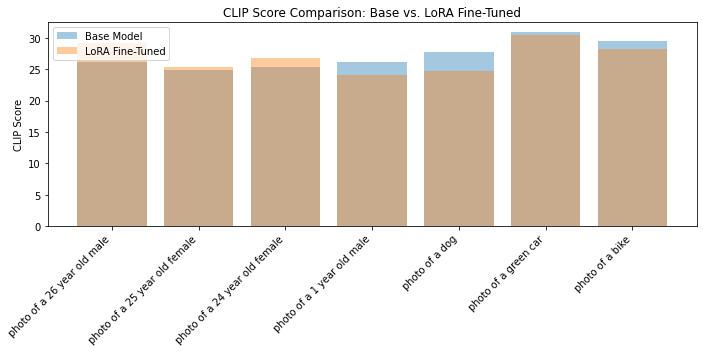

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Base Model Inference Time: 1.52 seconds
LoRA Model Inference Time: 1.51 seconds


In [36]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import os
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check CUDA availability
if torch.cuda.is_available():
    device = "cuda"
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("CUDA not available. Using CPU.")

# --- Model Loading ---
# Base model
base_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to(device)

# Fine-tuned model with LoRA
lora_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to(device)
lora_pipe.load_lora_weights(
    "/home/justin.aj/DFRL/new_method/utkface_lora_v1",
    weight_name="adapter_model.safetensors",
    local_files_only=True
)

# 3. Enable the LoRA adapter
lora_pipe.fuse_lora()

# --- CLIP Model for Evaluation ---
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# --- Prompts for Comparison ---
prompts = [
    "photo of a 26 year old male",
    "photo of a 25 year old female",
    "photo of a 24 year old female",
    "photo of a 1 year old male",
    "photo of a dog",  # Out-of-domain prompt to test generalization
    "photo of a green car",
    "photo of a bike"
]
fixed_generator = torch.Generator(device=device).manual_seed(42)

# --- Output Directory ---
os.makedirs("comparison_images", exist_ok=True)

# --- Image Generation and CLIP Score Calculation ---
clip_scores = {"base": [], "lora": []}
for prompt in prompts:
    # Generate images
    base_image = base_pipe(
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        height=512,
        width=512,
        generator=fixed_generator
    ).images[0]
    
    lora_image = lora_pipe(
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        height=512,
        width=512,
        generator=fixed_generator
    ).images[0]
    
    # Save images
    base_image.save(f"comparison_images/base_{prompt.replace(' ', '_')}.png")
    lora_image.save(f"comparison_images/lora_{prompt.replace(' ', '_')}.png")
    
    # Compute CLIP score
    inputs = clip_processor(text=[prompt], images=[base_image, lora_image], return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image  # [2, 1] for two images
    clip_scores["base"].append(logits_per_image[0].item())
    clip_scores["lora"].append(logits_per_image[1].item())
    
    print(f"Prompt: {prompt}")
    print(f"Base CLIP Score: {clip_scores['base'][-1]:.2f}")
    print(f"LoRA CLIP Score: {clip_scores['lora'][-1]:.2f}")
    print("-" * 50)

# --- Visualize CLIP Scores ---
plt.figure(figsize=(10, 5))
plt.bar(range(len(prompts)), clip_scores["base"], alpha=0.4, label="Base Model")
plt.bar(range(len(prompts)), clip_scores["lora"], alpha=0.4, label="LoRA Fine-Tuned")
plt.xticks(range(len(prompts)), prompts, rotation=45, ha="right")
plt.ylabel("CLIP Score")
plt.title("CLIP Score Comparison: Base vs. LoRA Fine-Tuned")
plt.legend()
plt.tight_layout()
plt.savefig("comparison_images/clip_score_comparison.png")
plt.show()

# --- Optional: Measure Inference Time ---
import time

start_time = time.time()
base_pipe(prompts[0], num_inference_steps=50, generator=fixed_generator)
base_time = time.time() - start_time

start_time = time.time()
lora_pipe(prompts[0], num_inference_steps=50, generator=fixed_generator)
lora_time = time.time() - start_time

print(f"Base Model Inference Time: {base_time:.2f} seconds")
print(f"LoRA Model Inference Time: {lora_time:.2f} seconds")

Caption Distribution:
photo of a 26 year old female: 1242 (5.24%)
photo of a 26 year old male: 955 (4.03%)
photo of a 1 year old male: 645 (2.72%)
photo of a 24 year old female: 595 (2.51%)
photo of a 35 year old male: 537 (2.27%)
photo of a 1 year old female: 478 (2.02%)
photo of a 28 year old male: 478 (2.02%)
photo of a 25 year old female: 446 (1.88%)
photo of a 28 year old female: 440 (1.86%)
photo of a 30 year old female: 377 (1.59%)
photo of a 30 year old male: 347 (1.46%)
photo of a 40 year old male: 346 (1.46%)
photo of a 35 year old female: 343 (1.45%)
photo of a 32 year old female: 334 (1.41%)
photo of a 45 year old male: 333 (1.40%)
photo of a 32 year old male: 330 (1.39%)
photo of a 27 year old female: 316 (1.33%)
photo of a 27 year old male: 299 (1.26%)
photo of a 25 year old male: 288 (1.21%)
photo of a 36 year old male: 288 (1.21%)
photo of a 23 year old female: 286 (1.21%)
photo of a 29 year old male: 285 (1.20%)
photo of a 29 year old female: 285 (1.20%)
photo of a 50 

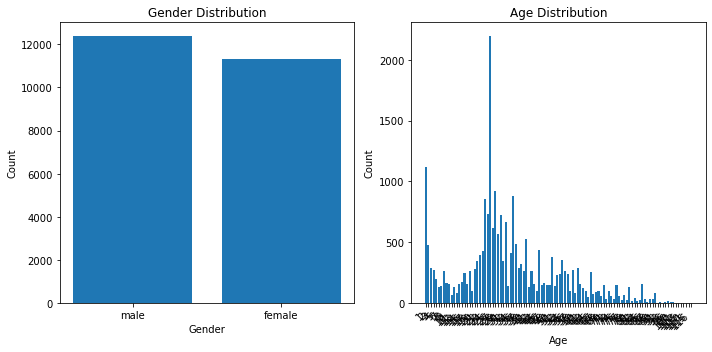

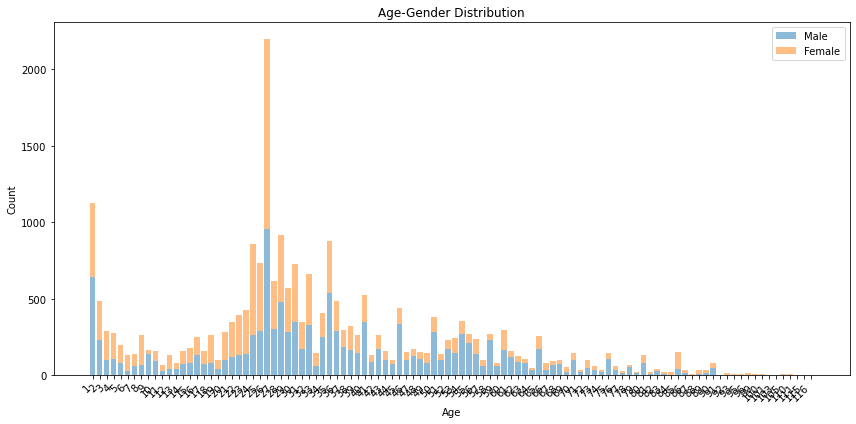

In [30]:
import os
import warnings
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import kagglehub

# UTKFaceDataset class (as provided)
class UTKFaceDataset(Dataset):
    def __init__(self, image_folder, caption_folder, resolution=512):
        self.image_paths = []
        self.caption_data = {}
        
        # Scan image folder
        for f in os.listdir(image_folder):
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".chip.jpg")):
                img_path = os.path.join(image_folder, f)
                self.image_paths.append(img_path)
                
                # Generate caption if missing
                base_name = os.path.basename(f)
                if base_name.endswith('.chip.jpg'):
                    caption_base = base_name.replace('.chip.jpg', '')
                else:
                    caption_base = os.path.splitext(base_name)[0]
                
                caption_path = os.path.join(caption_folder, f"{caption_base}.txt")
                
                # Create caption if file doesn't exist
                if not os.path.exists(caption_path):
                    try:
                        parts = base_name.split('_')
                        if len(parts) >= 3:  # Format: age_gender_race_date.jpg
                            age = parts[0]
                            gender = 'male' if parts[1] == '0' else 'female'
                            caption = f"photo of a {age} year old {gender}"
                            with open(caption_path, 'w') as f:
                                f.write(caption)
                    except Exception as e:
                        caption = "photo of a person"
                        warnings.warn(f"Couldn't generate caption for {base_name}: {str(e)}")
                
                # Store caption data
                self.caption_data[img_path] = caption_path

        self.transform = transforms.Compose([
            transforms.Resize(resolution),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Load image with error handling
        try:
            image = Image.open(img_path).convert("RGB")
            image = self.transform(image)
        except Exception as e:
            warnings.warn(f"Error loading image {img_path}: {str(e)}")
            # Return dummy data that won't affect training much
            image = torch.zeros(3, 512, 512)
            caption = "photo of a person"
            return image, caption
        
        # Get caption with error handling
        caption_path = self.caption_data[img_path]
        try:
            with open(caption_path, "r") as f:
                caption = f.read().strip()
        except Exception as e:
            warnings.warn(f"Error loading caption for {img_path}: {str(e)}")
            caption = "photo of a person"
        
        return image, caption

# --- Dataset Setup ---
dataset_path = kagglehub.dataset_download("jangedoo/utkface-new")
image_folder = os.path.join(dataset_path, "utkface_aligned_cropped/UTKFace")
caption_folder = os.path.join(image_folder, "captions")

# Initialize dataset
dataset = UTKFaceDataset(image_folder, caption_folder)

# --- Extract Captions ---
captions = []
for idx in range(len(dataset)):
    try:
        _, caption = dataset[idx]
        captions.append(caption)
    except Exception as e:
        print(f"Error processing index {idx}: {str(e)}")

# --- Analyze Class Balance ---
# Count captions
caption_counts = Counter(captions)

# Extract age and gender distributions
age_counts = Counter()
gender_counts = Counter()
age_gender_counts = Counter()

for caption in captions:
    if caption == "photo of a person":
        continue  # Skip generic captions
    parts = caption.split()
    age = parts[3]  # "photo of a {age} year old {gender}"
    gender = parts[6]
    age_counts[age] += 1
    gender_counts[gender] += 1
    age_gender_counts[f"{age}_{gender}"] += 1

# --- Print Results ---
print("Caption Distribution:")
for caption, count in caption_counts.most_common():
    print(f"{caption}: {count} ({count/len(captions)*100:.2f}%)")

print("\nGender Distribution:")
for gender, count in gender_counts.most_common():
    print(f"{gender}: {count} ({count/len(captions)*100:.2f}%)")

print("\nAge Distribution (Top 10):")
for age, count in age_counts.most_common(10):
    print(f"Age {age}: {count} ({count/len(captions)*100:.2f}%)")

print("\nAge-Gender Distribution (Top 10):")
for age_gender, count in age_gender_counts.most_common(10):
    print(f"{age_gender}: {count} ({count/len(captions)*100:.2f}%)")

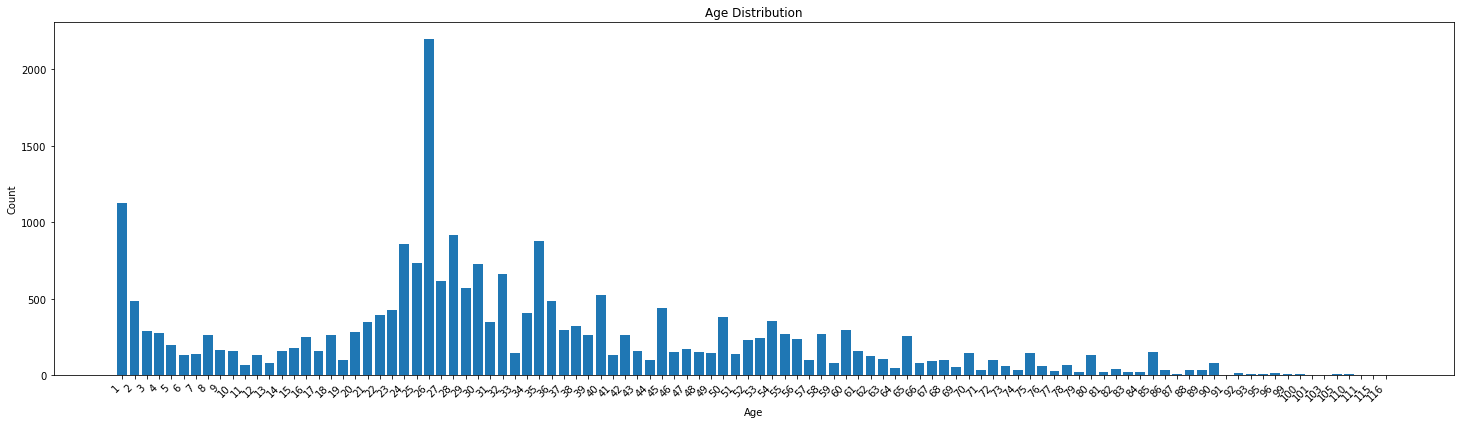

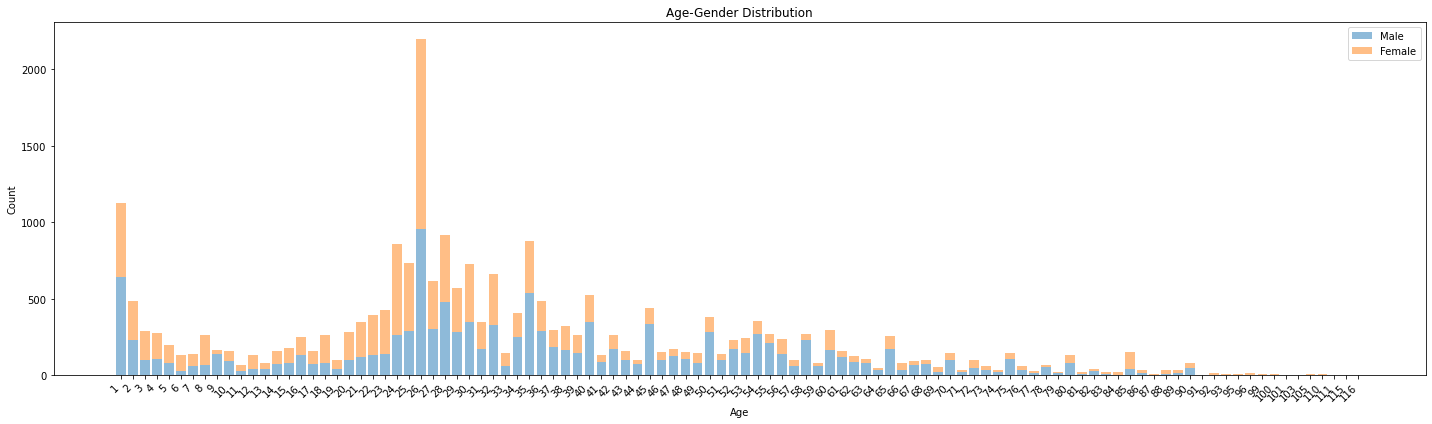

In [45]:
# --- Visualize Distributions ---
# Gender Distribution
plt.figure(figsize=(40, 6))
genders, gender_vals = zip(*gender_counts.most_common())
plt.bar(genders, gender_vals)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")

# Age Distribution
plt.subplot(1, 2, 2)
ages, age_vals = zip(*sorted(age_counts.items(), key=lambda x: int(x[0])))
plt.bar(ages, age_vals)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("utkface_class_balance.png")
plt.show()

# Optional: Age-Gender Stacked Bar
age_gender_data = {}
for age_gender, count in age_gender_counts.items():
    age, gender = age_gender.split('_')
    if age not in age_gender_data:
        age_gender_data[age] = {'male': 0, 'female': 0}
    age_gender_data[age][gender] = count

ages = sorted(age_gender_data.keys(), key=int)
male_counts = [age_gender_data[age]['male'] for age in ages]
female_counts = [age_gender_data[age]['female'] for age in ages]

plt.figure(figsize=(20, 6))
plt.bar(ages, male_counts, label="Male", alpha=0.5)
plt.bar(ages, female_counts, bottom=male_counts, label="Female", alpha=0.5)
plt.title("Age-Gender Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("utkface_age_gender_balance.png")
plt.show()

In [61]:
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
import torch
from PIL import Image
import os
import kagglehub
import pandas as pd

def age_face(pipe_img2img, input_image_path, gender, target_age, strength=0.35, guidance_scale=7.5, device="cuda"):
    # Construct the prompt with identity preservation
    gender_str = 'male' if gender == 'man' else 'female'
    prompt = f"portrait of the same {gender_str} at age {target_age}"
    negative_prompt = "generic face, blurry, distorted, different person"

    # Load and preprocess the input image
    init_image = Image.open(input_image_path).convert("RGB")
    init_image = init_image.resize((512, 512))

    # Perform img2img transformation
    with torch.autocast(device):
        output_image = pipe_img2img(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=init_image,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=100
        ).images[0]

    return init_image, output_image  # Return both input and output for visualization

def create_side_by_side_image(input_image, output_image, output_path):
    # Ensure both images are the same size
    input_image = input_image.resize((512, 512))
    output_image = output_image.resize((512, 512))

    # Create a new image with double the width to hold both images side by side
    combined_image = Image.new('RGB', (1024, 512))  # 512+512 width, 512 height
    combined_image.paste(input_image, (0, 0))  # Input on the left
    combined_image.paste(output_image, (512, 0))  # Output on the right

    # Save the combined image
    combined_image.save(output_path)

def process_csv_for_aging(csv_path, image_dir, output_dir, age_increase=30, device="cuda"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load and setup the pipeline once
    lora_pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    ).to(device)
    lora_pipe.load_lora_weights(
        "/home/justin.aj/DFRL/new_method/utkface_lora_v1",
        weight_name="adapter_model.safetensors",
        local_files_only=True
    )
    lora_pipe.fuse_lora()
    pipe_img2img = StableDiffusionImg2ImgPipeline(
        vae=lora_pipe.vae,
        text_encoder=lora_pipe.text_encoder,
        tokenizer=lora_pipe.tokenizer,
        unet=lora_pipe.unet,
        scheduler=lora_pipe.scheduler,
        safety_checker=None,
        requires_safety_checker=False,
        feature_extractor=None,
        image_encoder=None
    ).to(device)

    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Process each row in the CSV
    for index, row in df.iterrows():
        filename = row['filename']
        gender = row['gender']
        current_age = row['age']  # Get the current age from the CSV
        input_image_path = os.path.join(image_dir, f"{filename}.chip.jpg")

        # Compute the dynamic target age
        target_age = current_age + age_increase  # Increase age by 20 years

        # Check if the image exists
        if not os.path.exists(input_image_path):
            print(f"Image not found: {input_image_path}, skipping...")
            continue

        try:
            print(f"Processing {filename} (age {current_age} to {target_age})...")
            # Apply the aging transformation
            input_image, aged_image = age_face(
                pipe_img2img=pipe_img2img,
                input_image_path=input_image_path,
                gender=gender,
                target_age=target_age
            )

            # Create side-by-side visualization
            output_filename = os.path.splitext(filename)[0] + f"_aged_{target_age}_side_by_side.jpg"
            output_path = os.path.join(output_dir, output_filename)
            create_side_by_side_image(input_image, aged_image, output_path)
            print(f"Saved side-by-side image to {output_path}")

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

# Example usage
csv_path = "utk_train_balanced.csv"
dataset_path = kagglehub.dataset_download("jangedoo/utkface-new")
image_folder = os.path.join(dataset_path, "utkface_aligned_cropped/crop_part1")
image_dir = image_folder
output_dir = "aged_images"
age_increase = 20  # Increase age by 20 years

process_csv_for_aging(csv_path, image_dir, output_dir, age_increase=age_increase)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Processing 9_0_2_20170110215518068.jpg (age 9 to 29)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/9_0_2_20170110215518068_aged_29_side_by_side.jpg
Processing 8_1_2_20170109205424712.jpg (age 8 to 28)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/8_1_2_20170109205424712_aged_28_side_by_side.jpg
Processing 12_1_2_20170109203838187.jpg (age 12 to 32)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/12_1_2_20170109203838187_aged_32_side_by_side.jpg
Processing 13_0_2_20170103201143159.jpg (age 13 to 33)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/13_0_2_20170103201143159_aged_33_side_by_side.jpg
Processing 24_1_2_20170109213251114.jpg (age 24 to 44)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/24_1_2_20170109213251114_aged_44_side_by_side.jpg
Processing 66_0_2_20170111205753656.jpg (age 66 to 86)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/66_0_2_20170111205753656_aged_86_side_by_side.jpg
Processing 65_0_2_20170111205651706.jpg (age 65 to 85)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/65_0_2_20170111205651706_aged_85_side_by_side.jpg
Processing 69_1_2_20170111210824053.jpg (age 69 to 89)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/69_1_2_20170111210824053_aged_89_side_by_side.jpg
Processing 76_1_2_20170110182935621.jpg (age 76 to 96)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/76_1_2_20170110182935621_aged_96_side_by_side.jpg
Processing 75_0_2_20170111210029130.jpg (age 75 to 95)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/75_0_2_20170111210029130_aged_95_side_by_side.jpg
Processing 85_1_2_20170110175723033.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_1_2_20170110175723033_aged_105_side_by_side.jpg
Processing 82_0_2_20170111210110290.jpg (age 82 to 102)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/82_0_2_20170111210110290_aged_102_side_by_side.jpg
Processing 85_1_2_20170110181640900.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_1_2_20170110181640900_aged_105_side_by_side.jpg
Processing 80_0_2_20170111210646563.jpg (age 80 to 100)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/80_0_2_20170111210646563_aged_100_side_by_side.jpg
Processing 86_0_2_20170111210346308.jpg (age 86 to 106)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/86_0_2_20170111210346308_aged_106_side_by_side.jpg
Processing 96_1_2_20170110182504813.jpg (age 96 to 116)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/96_1_2_20170110182504813_aged_116_side_by_side.jpg
Processing 90_0_2_20170111210212331.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_2_20170111210212331_aged_110_side_by_side.jpg
Processing 90_1_2_20170111221639268.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_1_2_20170111221639268_aged_110_side_by_side.jpg
Processing 90_0_2_20170110183643228.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_2_20170110183643228_aged_110_side_by_side.jpg
Processing 90_0_2_20170111210301275.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_2_20170111210301275_aged_110_side_by_side.jpg
Image not found: /home/justin.aj/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/utkface_aligned_cropped/crop_part1/100_1_2_20170110182836729.jpg.chip.jpg, skipping...
Processing 9_0_1_20170110224349623.jpg (age 9 to 29)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/9_0_1_20170110224349623_aged_29_side_by_side.jpg
Processing 1_1_1_20170109194645713.jpg (age 1 to 21)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/1_1_1_20170109194645713_aged_21_side_by_side.jpg
Processing 9_0_1_20170110225612237.jpg (age 9 to 29)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/9_0_1_20170110225612237_aged_29_side_by_side.jpg
Processing 1_0_1_20170110213111809.jpg (age 1 to 21)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/1_0_1_20170110213111809_aged_21_side_by_side.jpg
Processing 3_0_1_20170110213659314.jpg (age 3 to 23)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/3_0_1_20170110213659314_aged_23_side_by_side.jpg
Processing 10_0_1_20170110225121326.jpg (age 10 to 30)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/10_0_1_20170110225121326_aged_30_side_by_side.jpg
Processing 10_1_1_20170109203520178.jpg (age 10 to 30)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/10_1_1_20170109203520178_aged_30_side_by_side.jpg
Processing 30_1_1_20170110120856819.jpg (age 30 to 50)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/30_1_1_20170110120856819_aged_50_side_by_side.jpg
Processing 45_0_1_20170111200809203.jpg (age 45 to 65)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/45_0_1_20170111200809203_aged_65_side_by_side.jpg
Processing 58_0_1_20170111210843429.jpg (age 58 to 78)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/58_0_1_20170111210843429_aged_78_side_by_side.jpg
Processing 60_1_1_20170110120140583.jpg (age 60 to 80)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/60_1_1_20170110120140583_aged_80_side_by_side.jpg
Processing 76_1_1_20170110181603235.jpg (age 76 to 96)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/76_1_1_20170110181603235_aged_96_side_by_side.jpg
Processing 75_0_1_20170111205805911.jpg (age 75 to 95)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/75_0_1_20170111205805911_aged_95_side_by_side.jpg
Processing 75_0_1_20170111210115928.jpg (age 75 to 95)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/75_0_1_20170111210115928_aged_95_side_by_side.jpg
Image not found: /home/justin.aj/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/utkface_aligned_cropped/crop_part1/75_0_1_20170111205412614.jpg.chip.jpg, skipping...
Processing 75_0_1_20170111210049339.jpg (age 75 to 95)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/75_0_1_20170111210049339_aged_95_side_by_side.jpg
Processing 88_1_1_20170110183118502.jpg (age 88 to 108)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/88_1_1_20170110183118502_aged_108_side_by_side.jpg
Image not found: /home/justin.aj/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/utkface_aligned_cropped/crop_part1/80_0_1_20170111205504634.jpg.chip.jpg, skipping...
Processing 80_0_1_20170111205416943.jpg (age 80 to 100)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/80_0_1_20170111205416943_aged_100_side_by_side.jpg
Processing 85_0_1_20170111211354288.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_0_1_20170111211354288_aged_105_side_by_side.jpg
Processing 80_0_1_20170111181750520.jpg (age 80 to 100)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/80_0_1_20170111181750520_aged_100_side_by_side.jpg
Image not found: /home/justin.aj/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/utkface_aligned_cropped/crop_part1/90_0_1_20170111210350530.jpg.chip.jpg, skipping...
Processing 90_0_1_20170111210246547.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_1_20170111210246547_aged_110_side_by_side.jpg
Processing 110_1_1_20170110155201038.jpg (age 110 to 130)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/110_1_1_20170110155201038_aged_130_side_by_side.jpg
Processing 6_0_3_20170110213739717.jpg (age 6 to 26)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/6_0_3_20170110213739717_aged_26_side_by_side.jpg
Processing 75_0_3_20170111202756116.jpg (age 75 to 95)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/75_0_3_20170111202756116_aged_95_side_by_side.jpg
Processing 85_1_3_20170110183506044.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_1_3_20170110183506044_aged_105_side_by_side.jpg
Processing 90_0_3_20170111210252274.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_3_20170111210252274_aged_110_side_by_side.jpg
Processing 110_1_3_20170110155139762.jpg (age 110 to 130)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/110_1_3_20170110155139762_aged_130_side_by_side.jpg
Processing 1_1_4_20170109194502921.jpg (age 1 to 21)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/1_1_4_20170109194502921_aged_21_side_by_side.jpg
Processing 8_1_4_20170109201742209.jpg (age 8 to 28)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/8_1_4_20170109201742209_aged_28_side_by_side.jpg
Processing 13_0_4_20170103201708406.jpg (age 13 to 33)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/13_0_4_20170103201708406_aged_33_side_by_side.jpg
Processing 15_1_4_20170103201247846.jpg (age 15 to 35)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/15_1_4_20170103201247846_aged_35_side_by_side.jpg
Processing 12_0_4_20170103201824880.jpg (age 12 to 32)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/12_0_4_20170103201824880_aged_32_side_by_side.jpg
Processing 13_1_4_20170103201542217.jpg (age 13 to 33)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/13_1_4_20170103201542217_aged_33_side_by_side.jpg
Processing 18_0_4_20170103201550447.jpg (age 18 to 38)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/18_0_4_20170103201550447_aged_38_side_by_side.jpg
Processing 63_1_4_20170110180156105.jpg (age 63 to 83)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/63_1_4_20170110180156105_aged_83_side_by_side.jpg
Processing 80_1_4_20170110184132973.jpg (age 80 to 100)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/80_1_4_20170110184132973_aged_100_side_by_side.jpg
Processing 8_1_0_20170109202339392.jpg (age 8 to 28)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/8_1_0_20170109202339392_aged_28_side_by_side.jpg
Processing 3_1_0_20170109192939414.jpg (age 3 to 23)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/3_1_0_20170109192939414_aged_23_side_by_side.jpg
Processing 8_1_0_20170109204836782.jpg (age 8 to 28)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/8_1_0_20170109204836782_aged_28_side_by_side.jpg
Processing 9_0_0_20170110215523228.jpg (age 9 to 29)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/9_0_0_20170110215523228_aged_29_side_by_side.jpg
Processing 4_0_0_20170110205422145.jpg (age 4 to 24)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/4_0_0_20170110205422145_aged_24_side_by_side.jpg
Processing 18_1_0_20170109214700491.jpg (age 18 to 38)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/18_1_0_20170109214700491_aged_38_side_by_side.jpg
Processing 17_0_0_20170110231535087.jpg (age 17 to 37)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/17_0_0_20170110231535087_aged_37_side_by_side.jpg
Processing 18_1_0_20170109214309566.jpg (age 18 to 38)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/18_1_0_20170109214309566_aged_38_side_by_side.jpg
Processing 14_1_0_20170109212926958.jpg (age 14 to 34)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/14_1_0_20170109212926958_aged_34_side_by_side.jpg
Processing 14_1_0_20170109213541777.jpg (age 14 to 34)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/14_1_0_20170109213541777_aged_34_side_by_side.jpg
Processing 20_1_0_20170103201716816.jpg (age 20 to 40)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/20_1_0_20170103201716816_aged_40_side_by_side.jpg
Processing 20_1_0_20170109213411083.jpg (age 20 to 40)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/20_1_0_20170109213411083_aged_40_side_by_side.jpg
Processing 23_0_0_20170111181750321.jpg (age 23 to 43)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/23_0_0_20170111181750321_aged_43_side_by_side.jpg
Processing 45_1_0_20170109221130179.jpg (age 45 to 65)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/45_1_0_20170109221130179_aged_65_side_by_side.jpg
Processing 47_1_0_20170109220517890.jpg (age 47 to 67)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/47_1_0_20170109220517890_aged_67_side_by_side.jpg
Processing 40_0_0_20170104204933500.jpg (age 40 to 60)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/40_0_0_20170104204933500_aged_60_side_by_side.jpg
Processing 56_1_0_20170110173815028.jpg (age 56 to 76)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/56_1_0_20170110173815028_aged_76_side_by_side.jpg
Processing 59_1_0_20170110141359968.jpg (age 59 to 79)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/59_1_0_20170110141359968_aged_79_side_by_side.jpg
Processing 52_0_0_20170111195709447.jpg (age 52 to 72)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/52_0_0_20170111195709447_aged_72_side_by_side.jpg
Processing 53_1_0_20170110160643204.jpg (age 53 to 73)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/53_1_0_20170110160643204_aged_73_side_by_side.jpg
Processing 56_0_0_20170111194856535.jpg (age 56 to 76)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/56_0_0_20170111194856535_aged_76_side_by_side.jpg
Processing 65_0_0_20170111203557764.jpg (age 65 to 85)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/65_0_0_20170111203557764_aged_85_side_by_side.jpg
Processing 65_1_0_20170110132512700.jpg (age 65 to 85)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/65_1_0_20170110132512700_aged_85_side_by_side.jpg
Processing 65_1_0_20170110160643938.jpg (age 65 to 85)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/65_1_0_20170110160643938_aged_85_side_by_side.jpg
Processing 64_1_0_20170110160643892.jpg (age 64 to 84)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/64_1_0_20170110160643892_aged_84_side_by_side.jpg
Processing 61_1_0_20170110160643735.jpg (age 61 to 81)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/61_1_0_20170110160643735_aged_81_side_by_side.jpg
Processing 71_1_0_20170110160644048.jpg (age 71 to 91)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/71_1_0_20170110160644048_aged_91_side_by_side.jpg
Processing 76_0_0_20170111210148707.jpg (age 76 to 96)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/76_0_0_20170111210148707_aged_96_side_by_side.jpg
Processing 77_1_0_20170110160644117.jpg (age 77 to 97)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/77_1_0_20170110160644117_aged_97_side_by_side.jpg
Processing 70_0_0_20170111210749134.jpg (age 70 to 90)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/70_0_0_20170111210749134_aged_90_side_by_side.jpg
Processing 75_1_0_20170110182459565.jpg (age 75 to 95)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/75_1_0_20170110182459565_aged_95_side_by_side.jpg
Processing 85_1_0_20170110155147409.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_1_0_20170110155147409_aged_105_side_by_side.jpg
Processing 85_1_0_20170110183700308.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_1_0_20170110183700308_aged_105_side_by_side.jpg
Processing 80_0_0_20170111211508161.jpg (age 80 to 100)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/80_0_0_20170111211508161_aged_100_side_by_side.jpg
Processing 85_1_0_20170110183711497.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_1_0_20170110183711497_aged_105_side_by_side.jpg
Processing 85_0_0_20170111205512345.jpg (age 85 to 105)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/85_0_0_20170111205512345_aged_105_side_by_side.jpg
Processing 90_1_0_20170110182426286.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_1_0_20170110182426286_aged_110_side_by_side.jpg
Processing 90_0_0_20170111205428761.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_0_20170111205428761_aged_110_side_by_side.jpg
Processing 93_1_0_20170110141221528.jpg (age 93 to 113)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/93_1_0_20170110141221528_aged_113_side_by_side.jpg
Processing 90_0_0_20170111222149759.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_0_20170111222149759_aged_110_side_by_side.jpg
Processing 90_0_0_20170111210338948.jpg (age 90 to 110)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/90_0_0_20170111210338948_aged_110_side_by_side.jpg
Processing 100_1_0_20170110183726390.jpg (age 100 to 120)...


  0%|          | 0/35 [00:00<?, ?it/s]

Saved side-by-side image to aged_images/100_1_0_20170110183726390_aged_120_side_by_side.jpg


In [3]:
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
import torch
from PIL import Image
import os
import kagglehub
import pandas as pd
import numpy as np
from insightface.app import FaceAnalysis

# Initialize FaceAnalysis once
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

def age_face(pipe_img2img, input_image_path, gender, target_age, strength=0.35, guidance_scale=7.5, device="cuda"):
    """Generate aged version of face with identity preservation"""
    gender_str = 'male' if gender == 'man' else 'female'
    prompt = f"portrait of the same {gender_str} at age {target_age}"
    negative_prompt = "blurry, low quality, distorted, extra eyes, extra teeth, glasses"

    init_image = Image.open(input_image_path).convert("RGB").resize((512, 512))
    
    with torch.autocast(device):
        output_image = pipe_img2img(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=init_image,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=100
        ).images[0]

    return init_image, output_image

def analyze_face(image_path, app):
    """Analyze face using InsightFace"""
    img = Image.open(image_path).convert("RGB")
    faces = app.get(np.array(img))
    return faces[0] if faces else None

def evaluate_pair(original_path, aged_path, target_age, app):
    """Evaluate age accuracy, gender preservation, and identity similarity"""
    try:
        orig_face = analyze_face(original_path, app)
        aged_face = analyze_face(aged_path, app)
        
        if not orig_face or not aged_face:
            return None
            
        return {
            'age_error': abs(aged_face['age'] - target_age),
            'gender_match': int(orig_face['gender'] == aged_face['gender']),
            'identity_similarity': np.dot(orig_face['embedding'], aged_face['embedding']) / 
                                  (np.linalg.norm(orig_face['embedding']) * np.linalg.norm(aged_face['embedding']))
        }
    except Exception as e:
        print(f"Evaluation error: {str(e)}")
        return None

def process_csv_for_aging(csv_path, image_dir, output_dir, age_increase=30, device="cuda"):
    """Main processing function with integrated evaluation"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize model
    lora_pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    ).to(device)
    lora_pipe.load_lora_weights(
        "/home/justin.aj/DFRL/new_method/utkface_lora_v1",
        weight_name="adapter_model.safetensors",
        local_files_only=True
    )
    lora_pipe.fuse_lora()
    
    pipe_img2img = StableDiffusionImg2ImgPipeline(
        vae=lora_pipe.vae,
        text_encoder=lora_pipe.text_encoder,
        tokenizer=lora_pipe.tokenizer,
        unet=lora_pipe.unet,
        scheduler=lora_pipe.scheduler,
        safety_checker=None
    ).to(device)

    # Metrics tracking
    metrics = {
        'age_errors': [],
        'gender_matches': [],
        'identity_scores': [],
        'processed_count': 0,
        'total_count': 0
    }

    df = pd.read_csv(csv_path)
    
    for index, row in df.iterrows():
        metrics['total_count'] += 1
        filename = row['filename']
        input_path = os.path.join(image_dir, f"{filename}.chip.jpg")
        
        if not os.path.exists(input_path):
            continue
            
        try:
            # Generate aged image
            input_img, aged_img = age_face(
                pipe_img2img=pipe_img2img,
                input_image_path=input_path,
                gender=row['gender'],
                target_age=row['age'] + age_increase
            )
            
            # Save outputs
            aged_path = os.path.join(output_dir, f"{filename}_aged.jpg")
            aged_img.save(aged_path)
            
            # Evaluate
            result = evaluate_pair(input_path, aged_path, row['age'] + age_increase, app)
            if result:
                metrics['age_errors'].append(result['age_error'])
                metrics['gender_matches'].append(result['gender_match'])
                metrics['identity_scores'].append(result['identity_similarity'])
                metrics['processed_count'] += 1
                
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Calculate final metrics
    detection_rate = metrics['processed_count'] / metrics['total_count'] * 100
    mae = np.mean(metrics['age_errors']) if metrics['age_errors'] else 0
    gender_acc = np.mean(metrics['gender_matches']) * 100 if metrics['gender_matches'] else 0
    identity_sim = np.mean(metrics['identity_scores']) if metrics['identity_scores'] else 0
    
    print("\nFinal Evaluation Results:")
    print(f"Detection Rate: {detection_rate:.1f}%")
    print(f"MAE: {mae:.2f} years")
    print(f"Gender Accuracy: {gender_acc:.1f}%")
    print(f"Identity Similarity: {identity_sim:.3f}")
    
    return metrics

# Example usage
if __name__ == "__main__":
    csv_path = "utk_train_balanced.csv"
    dataset_path = kagglehub.dataset_download("jangedoo/utkface-new")
    image_folder = os.path.join(dataset_path, "utkface_aligned_cropped/crop_part1")
    image_dir = image_folder
    output_dir = "aged_results"
    
    process_csv_for_aging(
        csv_path=csv_path,
        image_dir=image_dir,
        output_dir=output_dir,
        age_increase=20
    )

/home/justin.aj/.local/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


download_path: /home/justin.aj/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 89515.27KB/s] 


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/justin.aj/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/justin.aj/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/justin.aj/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/justin.aj/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/justin.aj/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

RuntimeError: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [2]:
!pip install onnxruntime

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.4 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 144 kB/s  eta 0:00:01
     |████████████████████████████████| 86 kB 265 kB/s  eta 0:00:01
